In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict
from copy import deepcopy

In [2]:
def log_arguments(fn): # note that function as input
    def new_function(*args,**kwargs): # we've seen these arguments before
        print ('positional arguments:')
        print (args)
        print ('keyword arguments:')
        print (kwargs)
        return fn(*args,**kwargs) # return a function
    return new_function

In [16]:
class FrozenLake:
    '''
    A class written to solve Question 1 in HW2, ECE276C at UCSD
    For more on frozenlake, check out - https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py
    
    The action have the following meanings:
        LEFT = 0
        DOWN = 1
        RIGHT = 2
        UP = 3
    '''
    def __init__(self, gamma):
        '''
        Initialize the frozen-lake environment
        '''
        assert isinstance(gamma, float) and 0.0<gamma<1.0, 'Invalid gamma'
        
        self.env = gym.make ("FrozenLake-v0")
        self.gamma = gamma
        self.numStates = self.env.observation_space.n
        self.numActions = self.env.action_space.n
        self.dt = 1
        self.mapAction = {
            0: 'left',
            1: 'down',
            2: 'right',
            3: 'up',
        }
        self.initial_state = self.env.reset() #reset env and return initial state
        print('Environment map:')
        self.printMap()

    def printMap(self):
        print(self.env.desc)
    
    def generateRollout(self, policy, maxT = 500, initial_state = 0):
        '''
        A rollout is a series of (state, action) pairs which goes on until time maxT or we reach a terminal state.
        A terminal state is reached when done = True in the following statement:
        
        >>> obs,r,done = env.step(action)
        '''
        assert isinstance(maxT, (int, float)), 'maxT needs to be int or float'
        assert isinstance(initial_state, int) and initial_state in range(self.numStates)
        assert isinstance(policy, np.ndarray) and len(policy) == self.numStates
        
        states = [initial_state]
        actions = []
        rewards = []
        
        for t in range(maxT):
            if policy == None:
                a = self.env.action_space.sample()
            else:
                a = policy(self, states[-1])
            # Take a step using action a
            next_state, r, done, info = env.step(a)
            # Save next state and the action that led to it
            states.append(next_state)
            actions.append(a)
            rewards.append(r)
            
            # Stop when we reach a terminal state
            if done:
                break

        assert len(states) - len(actions) == 1, 'Number of actions should be 1 less than number of states'
        assert len(states) - len(rewards) == 1, 'Number of rewards should be 1 less than number of states'
        
#         rollout = {
#             'state': states,
#             'action': actions,
#             'reward': rewards,
#         }
        rollout = (states, actions, rewards)
        return rollout
    
#     @log_arguments
    def TestPolicy(self, policy, num_trials=100, timeLimit = False, maxT=5000):
        '''
        Returns the average rate of successful episodes over 100 trials for a deterministic policy
        '''
        assert isinstance(policy, np.ndarray) and len(policy) == self.numStates
        assert isinstance(num_trials, int) and num_trials>0
        assert isinstance(timeLimit, bool)
        assert isinstance(maxT, int) and maxT>0
        
        success_count = 0
        for i in range(num_trials):
            t = 0
            state = int(self.env.reset()) #resetting state to initial position
            while(True):
                a = policy[state] #getting action from policy
                next_state, r, done, info = self.env.step(a) #taking a step using action
#                 print('next_state, r = ', next_state, r)
                # Check if we reached goal, i.e. check for success
                if (done and r == 1.0):
                    success_count += 1
                    break
                
                # Checking if we fell in a hole
                if done:
                    break
                
                if timeLimit and t>maxT:
                    print('Max time exceeded. Breaking out of loop')
                    break
                
                state = next_state ##### VERY IMPORTANT STEP!
                t += self.dt
        return success_count/num_trials

    def LearnModel(self, num_samples = 100000):
        '''
        Returns transition probabilities and reward function
        
        p(s'|a, s) is accessed by typing p[s][a][s']
        r(s,a,s') is accessed by typing r[s][a][s']
        '''
        assert isinstance(num_samples, int) and num_samples > 0
        
        self.env.reset()
        p = np.zeros((self.numStates, self.numActions, self.numStates))
        r = np.zeros((self.numStates, self.numActions, self.numStates))
        counter = np.zeros((self.numStates, self.numActions))
        self.count_s = np.zeros(self.numStates)
        self.count_a = np.zeros(self.numActions)
        
        for i in range(num_samples):
            s = np.random.randint(low = 0, high = self.numStates, dtype = int)
            a = np.random.randint(low = 0, high = self.numActions, dtype = int)
            self.count_s[s] += 1; self.count_a[a] += 1
            
            self.env.unwrapped.s = s #setting current state to randomly chosen state
            s_prime, reward, _, _ = self.env.step(a)
            
            p[s][a][s_prime] += 1
            r[s][a][s_prime] += reward
            counter[s][a] += 1
        
        #use itertools instead
        for s in range(self.numStates):
            for a in range(self.numActions):
                assert counter[s][a] != 0, 'Zero occurences of state-action pair. Cannot divide by 0'
                p[s][a][:] = p[s][a][:]/counter[s][a]
                r[s][a][:] = r[s][a][:]/counter[s][a]
        
        # Checking that probabilities sum to 1        
        for s in range(self.numStates):
            for a in range(self.numActions):
                assert abs(sum(p[s,a,:])-1.0) < 1e-4, 'Probabilities dont sum to 1 --> %f' % sum(p[s,a,:])
        
        return p, r, counter
    
    def initializeValueAndPolicyFunction(self, initial_value = 0):
        '''
        Initializes Value and Policy function and returns them
        All initial values for Value function are set to param initial_value
        Initial values for Policy function are chosen randomly between [0, number of actions)
        '''
        assert isinstance(initial_value, (int, float))
        
        V = np.zeros((self.numStates))
        policy = np.zeros((self.numStates))
        
        for s in range(self.numStates):
            a = np.random.randint(low = 0, high = self.numActions, dtype = int)
            V[s] = initial_value
            policy[s] = a
        
        return V, policy
    
    def evaluatePolicy(self, V, policy):
        '''
        Evaluates policy for 1 iteration
        '''
        assert isinstance(V, np.ndarray) and len(V) == self.numStates
        assert isinstance(policy, np.ndarray) and len(policy) == self.numStates
        
        gamma = self.gamma
        V_new = np.zeros_like(V)
        
        for s in range(self.numStates):
            a = policy[s]
            pf_s = self.env.P[s][a] #prob distribution over states for taking action a at state s
            # Calculating expected value of Value function coz of policy
            exp_V = 0.0
            for possible_sa_pairs in pf_s:
                prob, next_state, r, _ = possible_sa_pairs
                exp_V += prob*( r + gamma*V[next_state] ) 
            V_new[s] = exp_V
        return V_new
                
    def checkPolicyConvergence(self, V_old, V_new, threshold = 1e-3):
        '''
        Checks for convergence by checking if the maximum difference between value of all states 
        is less than some threshold
        '''
        assert isinstance(threshold, float) and 0 < threshold < 1
        assert isinstance(V_old, np.ndarray) and len(V_old) == self.numStates
        assert isinstance(V_new, np.ndarray) and len(V_new) == self.numStates
        
        max_diff = np.max(np.abs(V_old - V_new))
        success = max_diff<threshold
        return success, max_diff
    
    def repeatedlyEvaluatePolicy(self, V, policy, verbose = False):
        ''' Repeatedly evaluate policy until value function converges '''
        assert isinstance(V, np.ndarray) and len(V) == self.numStates
        assert isinstance(policy, np.ndarray) and len(policy) == self.numStates
        
        gamma = self.gamma
        # 2. Repeated policy Evaluation
        counter = 0
        while (True):
            # Step 1: Policy evaluation
            V_new = fl.evaluatePolicy(V, policy=policy)
            success, max_diff = fl.checkPolicyConvergence(V, V_new, threshold = 1e-3)
            V = V_new
            if success:
                break
            else:
                counter += 1
        if verbose:
            print('Policy Evaluation converged in %d iterations' % counter)
        return V
    
    def improvePolicy(self, V, policy, verbose = False):
        ''' Improve the policy '''
        assert isinstance(V, np.ndarray) and len(V) == self.numStates
        assert isinstance(policy, np.ndarray) and len(policy) == self.numStates
        
        policy_stable = True
        gamma = self.gamma

        for s in range(self.numStates):
            old_action = policy[s]
            # Calculating q_pi(s,a) (from slides) for all actions over which we'll do argmax to find optimal action a
            q_pi_sa = np.zeros((self.numActions))
            for a in range(self.numActions):
                pf_s = self.env.P[s][a] #prob distribution over states for taking action a at state s
                expectation = 0.0
                for possible_sa_pairs in pf_s:
                    prob, next_state, r, _ = possible_sa_pairs
                    expectation += prob*( r + gamma*V[next_state] ) 
                q_pi_sa[a] = expectation
            # Updating policy
            optimal_a = np.argmax(q_pi_sa)
            policy[s] = optimal_a 

            if old_action != optimal_a:
                policy_stable = False

        # Now we have a new imporved policy. Let's test its success rate
        success_rate = self.TestPolicy(policy, num_trials = 100, maxT = 5000)
        
        # Checking if policy has converged
        if policy_stable:
            return True, success_rate, policy
        else:
            return False, success_rate, policy
    
    def doPolicyIteration(self, verbose = False):
        ''' Implement policy iteration '''
        
        # 1. Initialize policy and value function
        V, policy = self.initializeValueAndPolicyFunction()
        i, avg_success = 0, []
        
        for i in range(50):
            # 2. Repeatedly evaluate policy till Value function converges
            V = self.repeatedlyEvaluatePolicy(V, policy, verbose = verbose)

            # 3. Policy Improvement
            success, success_rate, policy = self.improvePolicy(V, policy)
            avg_success.append(success_rate)
            
#             if success:
#                 break
#             else:
#                 i += 1
#         if verbose:
#             print('----->Policy improvement converged in %d iterations' % i)
        
        return V, policy, avg_success
    
    def doValueIteration(self, threshold = 1e-3, verbose = False):
        ''' Implement value iteration '''
        gamma = self.gamma
        # 1. Initialize V
        V, _ = self.initializeValueAndPolicyFunction()
        # 2. Initialize delta
        delta = np.inf
        # 3. Improve V over all states and then repeat until delta is less than some threshold
        i = 0
        while(delta > threshold):
            delta = 0
            for s in range(self.numStates):
                v = deepcopy(V[s])
                allActionsResult = self.getExpectationOverAction(V, s)
                assert allActionsResult.shape == (self.numActions, ), 'Needs to be a 1D ndarray'
                V[s] = np.max(allActionsResult)
                delta = max(delta, abs(v - V[s]))
            
            i += 1
            # Getting policy from value function
            policy = self.getPolicyFromValueFunction(V)
            avg_success_rate = self.TestPolicy(policy, num_trials = 100, maxT = 5000)
        
        if verbose:
            print('Value iteration converged in {0} iterations with final delta = {1}'.format(i, delta))
        
        return V
        
    def getExpectationOverAction(self, V, s):
        '''
        Calculate the expected value of all actions at state s
        '''
        assert isinstance(s, int) and s in range(self.numStates)
        assert isinstance(V, np.ndarray) and len(V) == self.numStates
        
        gamma = self.gamma
        allActionsResult = np.zeros((self.numActions))
        for a in range(self.numActions):
            result_for_sa = self.env.P[s][a]
            for sa in result_for_sa:
                prob, next_state, r, _ = sa
                allActionsResult[a] += prob*( r + gamma*V[next_state] )
        return allActionsResult
    
    # POSSIBLE BUG -----> different gamma values can be used while calculating value function and deriving policy
    
    def getPolicyFromValueFunction(self, V):
        '''
        Deriving optimal policy using value function
        '''
        
        gamma = self.gamma
        # 1. Initialize policy
        _, policy = self.initializeValueAndPolicyFunction()
        # 2. Get optimal action for each state
        for s in range(self.numActions):
            allActionsResult = self.getExpectationOverAction(V, s)
            assert allActionsResult.shape == (self.numActions, ), 'Needs to be a 1D ndarray'
            policy[s] = np.argmax(allActionsResult)
        return policy
    
    def plotPolicy(self, policy):
        '''
        Plot policy in words
        '''
        assert isinstance(policy, np.ndarray) and len(policy) == self.numStates
        
        for i, s in enumerate(range(self.numStates), 1):
            a = policy[s]
            print(self.mapAction[a] + '\t', end='')
            if i%4 == 0:
                print('\n')
    
    def initializeQFunction(self, initial_value = 0): ######----> recognize terminal states and set them to 0 separately
        ''' Initialize Q(s,a) for all (s,a) pairs to initial value '''
        assert isinstance(initial_value, (int, float))
        
        Q = np.ones((self.numStates, self.numActions))
        Q = Q*initial_value
        return Q
    
    def getPolicyFromQFunction(self, Q):
        ''' Derive optimal policy from Q function'''
        
        policy, _ = self.initializeValueAndPolicyFunction()
        for s in range(self.numStates):
            optimal_action = np.argmax(Q[s,:])
            policy[s] = optimal_action
        
        return policy
    
    
    def doQLearning(self, gamma, alpha, num_episodes=5000):
        ''' Implement off-policy Q learning '''
        assert isinstance(gamma, float) and 0<gamma<1
        assert isinstance(alpha, float) and 0<alpha<1
        
        avg_success = []
        # 1. Initialize Q function
        Q = self.initializeQFunction()
        for i in range(1, num_episodes+1):
            # 2. Get policy from Q function
            policy = self.getPolicyFromQFunction(Q)
            if (i%100 == 0):
                avg_success.append(self.TestPolicy(policy, num_trials=100))
            # 3. Initialize State
            s_t1 = self.env.reset()
            # 4. Learning from each step of episode until terminal state is reached
            Q_new = deepcopy(Q)
            done = False
            while not(done):
                greedy_action = policy[s_t1]
                random_action = self.env.action_space.sample()
                a_t1 = int(np.random.choice([greedy_action, random_action], p = [i/5000, 1 - (i/5000)]))
                s_t2, r_t1, done, info = self.env.step(a_t1)
                Q_max_a = np.max(Q[s_t2,:])
                Q_new[s_t1, a_t1] = Q[s_t1, a_t1] + alpha*(r_t1 + gamma*Q_max_a - Q[s_t1, a_t1])
                s_t1 = s_t2 #advancing to next state
            Q = Q_new
        return Q, avg_success

In [17]:
fl = FrozenLake(gamma = 0.9)
# Forming test policy
policyTest = np.zeros((fl.numStates))
for s in range(fl.numStates):
    policyTest[s] = (s+1)%4

success_rate = fl.TestPolicy(policyTest, num_trials = 100, maxT = 5000)
print('\nSuccess Rate for policy is: %.3f' % (success_rate))
# p, r, counter = fl.LearnModel()

Environment map:
[[b'S' b'F' b'F' b'F']
 [b'F' b'H' b'F' b'H']
 [b'F' b'F' b'F' b'H']
 [b'H' b'F' b'F' b'G']]

Success Rate for policy is: 0.030


Text(0.5, 1.0, 'Average success rate vs iterations for Policy Iteration')

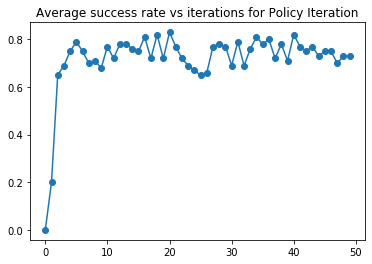

In [18]:
V, policy, avg_success_PI = fl.doPolicyIteration(verbose=False)
fig, axs = plt.subplots()
axs.plot(range(len(avg_success_PI)), avg_success_PI, '-o')
axs.set_title('Average success rate vs iterations for Policy Iteration')

In [19]:
fl.plotPolicy(policy)
print(policy.reshape(4,4))

left	up	left	up	

left	left	left	left	

up	down	left	left	

left	right	down	left	

[[0. 3. 0. 3.]
 [0. 0. 0. 0.]
 [3. 1. 0. 0.]
 [0. 2. 1. 0.]]


In [20]:
Q, avg_success_QL  = fl.doQLearning(gamma = 0.99, alpha = 0.1, num_episodes=5000)

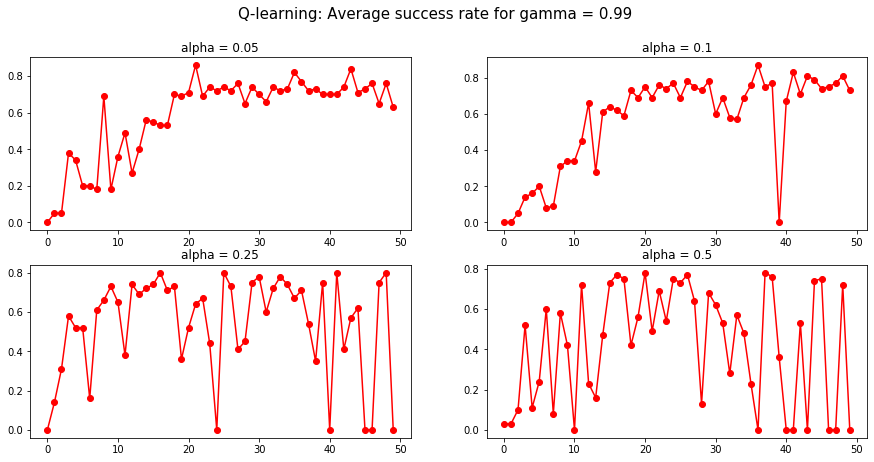

In [34]:
gamma, alpha = 0.99, [0.05, 0.1, 0.25, 0.5]
fig, axs = plt.subplots(2,2, figsize=(15,7))
axs = axs.flatten()
fig.suptitle("Q-learning: Average success rate for gamma = {0}".format(gamma), fontsize=15)
for i in range(len(alpha)):
    _, avg_success_QL = fl.doQLearning(gamma = gamma, alpha = alpha[i], num_episodes=5000)
    axs[i].plot(range(len(avg_success_QL)), avg_success_QL, 'r-o')
    axs[i].set_title('alpha = {0}'.format(alpha[i]))

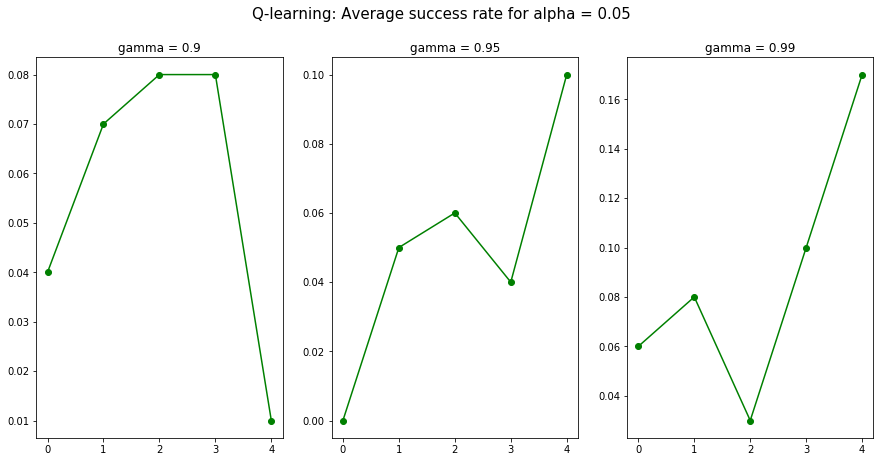

In [36]:
alpha, gamma = 0.05, [0.9, 0.95, 0.99]
fig, axs = plt.subplots(1,3, figsize=(15, 7))
axs = axs.flatten()
fig.suptitle("Q-learning: Average success rate for alpha = {0}".format(alpha), fontsize=15)
for i in range(len(gamma)):
    _, avg_success_QL = fl.doQLearning(gamma = gamma[i], alpha = alpha, num_episodes=500)
    axs[i].plot(range(len(avg_success_QL)), avg_success_QL, 'g-o')
    axs[i].set_title('gamma = {0}'.format(gamma[i]))